In [612]:
import numpy as np
import heapq
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

The data set used in this project represents RNA-seq data from 100 different (fictional) genes, which are grouped into 'batteries' which are co-expressed. The task in this project is to a) determine how many batteries there are, along with the genes contained within them, and b) determine a subset of genes (moonlighting genes) which are part of more than one battery. To solve this problem, I use Non-negative Matrix Factorization (NMF).

In the code below, I write a script that uses the generative model assumed by NMF to create synthetic data for N genes, M experiments, and R underlying genes. I randomly choose 4 moonlighting genes, but otherwise the R batteries are disjoint. 

In [850]:
N, M, R = 100, 60, 4
C = 1e6

#initialize the shape of the  W matrix
W = np.zeros((N,R))

#assign each gene randomly to a module
for i in range(len(W)):
    module = np.random.choice(R)
    W[i][module] = 1

#create a few randomly chosen moonlighting genes
num_moonlight = 4
moonlights = np.random.choice(100, num_moonlight, replace=False)

for element in moonlights:
    #randomly choose which other module to be assigned to
    temp = []
    for i, j in enumerate(W[element]):
        if j == 0:
            temp.append(i)
    module = np.random.choice(temp)
    W[element][module] = 1

#this step necessary to deal with inability of np.random.dirichlet to take 0 as an alpha value
a = np.sum(W, axis = 0)

#finalize my W matrix
for i in range(R):
    temp_vals = []
    temp_indicies = []
    for j, k in enumerate(W[:,i]):
        if k == 1:
            temp_indicies.append(j)
            temp_vals.append(k)
    #dirichlet ensures random column values add to 1
    new_vals = np.random.dirichlet(temp_vals)
    for l, index in enumerate(temp_indicies):
        W[index][i] = new_vals[l]

#sanity check that columns sum to 1
print(np.sum(W, axis = 0))

#create H matrix (dirichlet ensures columns add to 1)
H = np.ones((R,M))
H = np.apply_along_axis(np.random.dirichlet,0, H)

#generate V
V = W@H

#add poisson noise
V = np.random.poisson(C * V)

[1. 1. 1. 1.]


In the following lines, I define a function to get the log likelihood of achieving our V matrix given W and H. Note that the returned values are only pseudo-log likelihoods because I ignore the log(V_iu!) term from the calculation - this is valid given that it is independent of W and H so will not change our calculations when we optimize W and H.

In [876]:
def get_ll(W, H, V):
    C = np.sum(V, axis = 0)    
    expected_V = (W@H) * C
    ll = (V*np.log(expected_V) - expected_V).sum()
    
    return(ll)

Next, I write functions to update our H and W matrices along the lines of the multiplicative updating in the method put forth by Lee and Seung.

In [877]:
def update_H(W, H, V):
    C = np.sum(V, axis = 0)
    expected_V = (W@H) * C
    new_H = np.zeros(H.shape)
    for a in range(H.shape[0]):
        for mu in range(H.shape[1]):
            new_H[a][mu] = 0
            for i in range(V.shape[0]):
                new_H[a][mu] += (V[i][mu]/expected_V[i][mu])*W[i][a]
            new_H[a][mu] = new_H[a][mu]*H[a][mu]
    return new_H

In [878]:
def update_W(W, H, V):
    C = np.sum(V, axis = 0)
    expected_V = (W@H) * C
    new_W = np.zeros(W.shape)
    #print('W',new_W.shape)
    for i in range(W.shape[0]):
        for a in range(W.shape[1]):
            new_W[i][a] = 0
            for mu in range(V.shape[1]):
                new_W[i][a] += (V[i][mu]/expected_V[i][mu])*np.sum(V[:,mu])*H[a][mu]
            new_W[i][a] = new_W[i][a]*W[i][a]
            
    #normalization step
    new_W = new_W/new_W.sum(axis=0)
    return new_W

Finally, I create the NMF function that, starting with random W and H matrices, calculates the log likelihood of a given estimate, then updates the estimated W and H matices and iterates the process until the log likelihoods converge to an optimum. Since the function is not convex, we want to try a few different initial guesses of W and H to try to find the global (or close-to-global) optimum.

In [879]:
def NMF(V, R):
    N = 100
    M = 60
    best_ll = -float('inf')
    for i in range(3):
        init_W = np.ones((N,R))
        init_W = np.apply_along_axis(np.random.dirichlet,0, init_W)

        init_H = np.ones((R,M))
        init_H = np.apply_along_axis(np.random.dirichlet,0, init_H)

        new_W = update_W(init_W, init_H, V)
        new_H = update_H(init_W, init_H, V)

        current_W = new_W
        current_H = new_H

        ll_last = -float('inf')
        ll = get_ll(new_W, new_H, V)

        while ll - ll_last > 0.00001 * ll_last:
            ll_last = ll
            new_W = update_W(current_W, current_H, V)
            new_H = update_H(current_W, current_H, V)
            ll = get_ll(new_W, new_H, V)

            current_W = new_W
            current_H = new_H
        print(ll)
        if ll > best_ll:
            best_ll = ll
            final_H = new_H
            final_W = new_W
    
    return final_H, final_W

In the next line, I call my NMF function to find the predicted H and W matrices for my synthetic data given the true R value.

In [900]:
pred_H, pred_W = NMF(V, 4)

539034616.7596222
539007297.658366
538700742.6522715


For comparison, it would be helpful to compare the log likelihood of V given our predicted W and H with that of V given the true W and H. This is shown below.

In [901]:
exp_ll = get_ll(pred_W, pred_H, V)
print("The LL given the true W and H is %i" %(get_ll(W, H, V)))
print("The LL given the estimated W and H is %i" %(get_ll(pred_W, pred_H, V)))

The LL given the true W and H is 539105747
The LL given the estimated W and H is 539034616


The similarity of these values indicates that the NMF generated a fairly good estimation of W and H.

The following heatmap shows the clustering of each gene to each battery - the coloring refers to the probability of a gene belonging to a given battery. In all non-moonlighing rows, there should only be one non-black cell. Note that each gene corresponds to a number in these (writing the full names would create a cluttered graph).

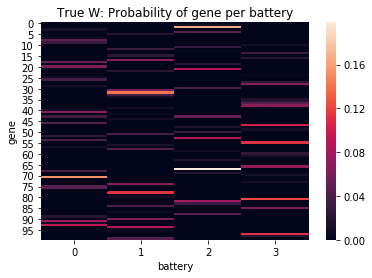

In [902]:
plot = sns.heatmap(W)
plot.set(xlabel = "battery", ylabel = "gene")
plot.set_title("True W: Probability of gene per battery");

Next, I plot the same heatmap for the predicted W matrix. Ideally, the clustering that we see should mirror that shown in the plot above.

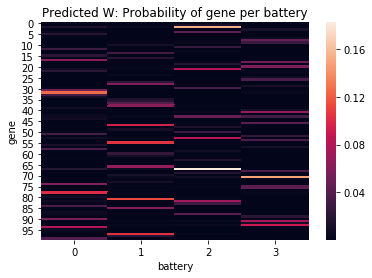

In [903]:
plot = sns.heatmap(pred_W)
plot.set(xlabel = "battery", ylabel = "gene")
plot.set_title("Predicted W: Probability of gene per battery");

At first glance, the clustering of the genes into batteries as shown by the true W and the predicted W seem quite different. For example, simply looking by eye to compare the location of bright bands in specific columns makes it seem as though the two heatmaps are completely different. On second glance, however, one can note that, while the columns are not consistently ordered, the two graphs are actually nearly identical, but simply have columns switched. This makes sense because when clustering genes to batteries, the NMF algorithm doesn't differentiate between, say, battery 1 and battery 2 as inherently different - rather, the label of the battery is arbitrary so there is no reason to expect that the labels from our initialization should remain consistent. When taking this into account, we can see that the columns match quite closely, though out of order, indicating that the model generated good estimations of W and H. However, we need to do some more exploration to verify this intuition.

Next, we normalize each value of W by the sum of the row - this will eventually help us find the predicted moonlighting genes, and makes the difference between highly probable and unlikely batteries for each gene more standardized and easy to interpret.

In [904]:
for i in range(len(pred_W)):
    norm = pred_W[i].sum()
    for mu in range(R):
        pred_W[i][mu] = pred_W[i][mu]/norm

Now that each value in pred_W has been normalized by the sum of the row, we can visualize our results in a histogram. In the following histogram, each color represents a battery, and we see the frequency of achieving each probability for each battery.

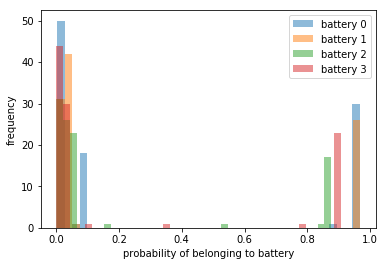

In [905]:
for i in range(R):
    plt.hist(pred_W[:, i], alpha = 0.5, bins = 40, label = "battery " + str(i));

plt.ylabel ('frequency');
plt.xlabel ('probability of belonging to battery');
plt.legend();

We see that only roughly 20-30 genes per battery have a probability higher than about 0.85 of belonging to a particular battery - this is exactly what we would expect, given that for my parameters, each of the 100 genes should be divided randomly to one of 4 batteries. We can also see in the center part of the histogram a few rare instances of of middling probabilities - these are likely our moonlighting genes, which have a not-insignificant probability of being assigned to one of two batteries.

Next, we find the genes in each of the true batteries and the genes in each battery according to our NMF prediction.

In [906]:
clusters = [set(), set(), set(), set()]
for j in range(R):
    for i in range(len(W)):
        if W[i][j] > 0:
            clusters[j].add(i)


In [907]:
clusters_pred = [set(), set(), set(), set()]
#find the maximum value in each row and store the battery associated with it
for i in range(len(pred_W)):
    clusters_pred[np.argmax(pred_W[i])].add(i)


In [908]:
best_score = 0

#Find the maximum size of the intersection between intersection of each true cluster with each predicted cluster to get the number of correctly assigned genes 
for cluster in clusters:
    temp = max(len(cluster.intersection(cluster_pred)) for cluster_pred in clusters_pred)
    best_score += temp

print("The clustering algorithm correctly characterized %i/100 of the clusters" %(best_score))

The clustering algorithm correctly characterized 100/100 of the clusters


This result shows that the algorithm correctly assigned each gene to its battery. Note that for this step, the characterization of each gene did not include the extra battery assigned to moonlighting genes.

Now, we need to see if the algorithm correctly identitifed moonlighting genes. Above, I mentioned how from the histogram we can see some of the moonlighting genes by eye, by simply noting the genes that have middling probability values of belonging to a particular battery - this indicates that these genes also have a significant probability of being assigned to a second battery. Thus, in order to check which genes the algorithm identifies as moonlighting, we can check to see which genes have (normalized) probabilities of being in a particular battery that falls within a range of middling values. Below, I use the cutoffs as falling between 0.15 and 0.85 - this threshold is not inherently absolute, but should give a good estimated cutoff based by eye on the results from the histogram plotted above. For different histograms, we should consider different threshold values.

In [910]:
moonlighters = []
for i in range(len(pred_W)):
    for j in range(R):
        if 0.15 < pred_W[i][j] < 0.85:
            moonlighters.append(i)
            break
print("The predicted moonlighting genes are ", sorted(moonlighters))
print("The true moonlighting genes are ", sorted(moonlights))

The predicted moonlighting genes are  [9, 30, 43]
The true moonlighting genes are  [9, 22, 30, 43]


For this particular case, we can see that the NMF algorithm correctly identified 3/4 of the moonlighting genes. From this, we might be tempted to conclude that our algorithm works quite well. While it definitely seems to be working very well, we need to be cognizant of its potential downsides. First, because the algorithm is prone to finding local optima, in order ensure the validity of our results as applied to this and other data, we should consider runing the NMF with many more starting conditions. Furthermore, even if our algorithm reached a global, or near-global optimum, it is possible that this surface could resemble a plateau, whereby the parameters could change in significant way while the log likelihood would remain near-constant. This could be especially problematic in future experiments for finding the moonlighting genes, which relies on our finding relative probabilities within a middling range. This could potentially explain why only 3 out of the 4 true moonlighting genes were identified for this synthetic data set using my model. 

For comparison's sake, it would be helpful to see how well the NMF algorithm finds moonlighting genes if run with an R value that is different from the true value. Below, I rerun the NMF on the synthetic data, but this time using R = 3.

In [911]:
new_pred_H, new_pred_W = NMF(V, 3)

534350839.1801518
534308770.95481753
534380061.88577974


In [912]:
print("The LL given the true W and H is %i" %(get_ll(W, H, V)))
print("The LL given the estimated W and H from our initial experiment with R = 4 is %i" %(exp_ll))
print("The LL given the estimated W and H from this new experiment where R = 3 (wrong), is %i" %(get_ll(new_pred_W, new_pred_H, V)))

The LL given the true W and H is 539105747
The LL given the estimated W and H from our initial experiment with R = 4 is 539034616
The LL given the estimated W and H from this new experiment where R = 3 (wrong), is 534380061


We can see that the log likelihood of the new W and H matrices given R=3 is significantly lower than the log likelihood as calculated with the true W and H or the W and H generated from our initial estimated given R = 4. 

Now we can see what the algorithm estimates the partitioning into three batteries looks like with R=3.

In [913]:
#normalization step
for i in range(len(new_pred_W)):
    norm = new_pred_W[i].sum()
    for mu in range(3):
        new_pred_W[i][mu] = new_pred_W[i][mu]/norm

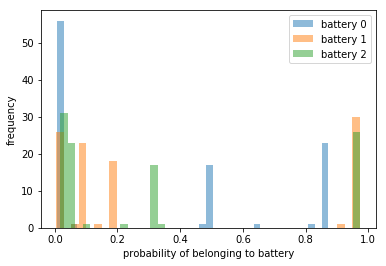

In [914]:
for i in range(3):
    plt.hist(new_pred_W[:, i], alpha = 0.5, bins = 40, label = "battery " + str(i));

plt.ylabel ('frequency');
plt.xlabel ('probability of belonging to battery');
plt.legend();

By eye, we can see that with R=3, the algorithm is much less good at assigning genes to a single battery, as there are many genes in the middle of the histogram (many more than there are moonlighting genes). Following the same method as we did with our initial experiment, we can see which genes are predicted to be moonlighting genes.

In [915]:
moonlighters = []
for i in range(len(new_pred_W)):
    for j in range(3):
        if 0.15 < new_pred_W[i][j] < 0.85:
            moonlighters.append(i)
            break
print("The predicted moonlighting genes from this new estimate with R=3 are ", sorted(moonlighters))

The predicted moonlighting genes from this new estimate with R=3 are  [1, 2, 4, 9, 11, 13, 19, 21, 30, 43, 48, 50, 53, 59, 63, 67, 69, 82, 83, 88]


As expected, with R=3, the algorithm can neither accurately partition the genes into batteries nor identify moonlighting genes correctly. In the next problem, we consider what would happen if we allowed more degrees of freedom in our model - that is, what would happen if we allowed more batteries than the true number to be at play, rather than fewer as in the case of R=3.

# Problem 3 

In [916]:
! wget -o - "http://mcb112.org/w10/w10-data.tbl" > get.log

Here, I read adler's data into a form that can then be analyzed.

In [917]:
adler_data = pd.read_table("w10-data.tbl", header = None, delim_whitespace = True, index_col = 0)
adler_data

,1,2,3,4,5,6,7,8,9,10,...,51,52,53,54,55,56,57,58,59,60
0,,,,,,,,,,,,,,,,,,,,,
anise,2822,1639,830,891,367,2148,505,967,971,2181,...,273,252,2425,1599,427,1476,1511,182,717,1730
apricot,2917,1650,885,945,375,2175,537,986,975,2191,...,301,233,2412,1568,445,1479,1463,184,680,1788
artichoke,254,347,496,767,109,695,625,676,1139,107,...,764,354,901,1647,1020,858,991,315,473,439
arugula,1786,1058,575,605,228,1517,342,678,629,1524,...,173,142,1664,1068,304,939,1000,134,424,1164
asparagus,1345,1606,2591,3845,547,3241,3061,3657,5839,633,...,3792,1725,4780,8285,5392,4283,4812,1687,2261,2289
avocado,355,1125,1504,504,2042,601,649,1048,748,1281,...,273,508,527,63,68,1025,289,2387,1281,119
banana,1189,1433,2237,3319,488,2894,2764,2988,5150,550,...,3305,1497,4234,7323,4590,3700,4266,1428,1999,1930
basil,453,1401,1812,594,2396,736,797,1326,896,1572,...,372,644,640,65,62,1230,319,2821,1590,144
beet,2257,876,1210,3709,2003,393,3621,1448,1153,266,...,3662,4579,62,254,3503,574,1304,1483,1580,2779


In order to figure out what the best R value is, I find the log likelihood of adler's data given the W and H matrices generated using anywhere from 3 to 6 batteries. Then, I plot the resulting log likelihoods against the R values.

In [918]:
y=[]
for r in range(3,7):
    pred_H, pred_W = NMF(adler_data.values, r) 
    y.append(get_ll(pred_W, pred_H, adler_data.values))

38793297.156947084
38721101.731096104
38723416.7814662
39253603.63617641
39250177.867286935
39255395.60325553
39256942.00350049
39256027.6326123
39257222.29048379
39257360.43994355
39257624.00822601
39258069.260873705


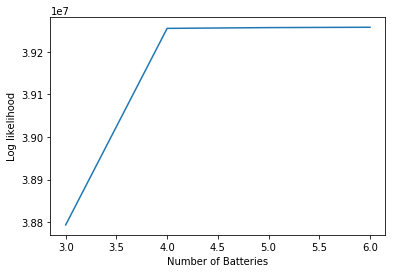

In [919]:
plt.plot([3, 4, 5, 6], y);
plt.xlabel('Number of Batteries');
plt.ylabel('Log likelihood');

As we see from this plot, having 3 batteries is clearly the least likely, but having 4, 5, or 6 batteries produces results with similar log likelihoods. So, how can we discern which value is the correct one?  If we think about the significance of adding extra possible batteries, it becomes apparent that most likely, the correct number of batteries is 4. 

It is clear that running our model on an R value that is lower than the true R value should produce a much lower LL value than with the true R value; there are simply not enough parameters for the model to accurately fit the data. This is clearly the case with the R=3 case above, and we showed a similar result in problem 2. However it is not as immediately clear that the LL should decrease if we use an R value that is greater than the true value. In fact, we might even expect it to increase, but  only by a marginal amount; this is because, even though it doesn't reflect the true situation, the added flexibility granted by extra parameters would create more possibility for fitting the data better, meaning that the LL wouldn't decrease, and may actually increase a bit.

So in order to determine what the true R value is, we should look for the value at which the log likelihood plateaus. In the graph above, this value is clearly when R=4. As expected, when R=3, the LL is much lower, and when R=5 or 6, the LL perhaps increases marginally. However, the increase in LL with R = 5 or 6 is clearly insignificant enough to suggest that the increase is an artifact of adding extra freedom with more parameters, and not a truly biological phenomenon. From this, we conclude that the most likely R value is 4.

Given this conclusion, I now run the NMF algorithm given R=4 on adler's data to find our estimated W and H matrices

In [927]:
pred_H, pred_W = NMF(adler_data.values, 4)

39253901.47578406
39251927.15047273
39254325.48115572


Now, I normalize each cell in the W matrix by the sum of the row.

In [928]:
for i in range(len(pred_W)):
    norm = pred_W[i].sum()
    for mu in range(R):
        pred_W[i][mu] = pred_W[i][mu]/norm

Finally, in order to find the moonlighting genes, I find the genes which contain probability values in a middling range, along the same reasoning as outlined in problem 2.

In [929]:
moonlighters = []
for i in range(len(pred_W)):
    for j in range(4):
        if 0.2 < pred_W[i][j] < 0.8:
            moonlighters.append((i,j))
print(moonlighters)
moonlighters_set = set()
for element in moonlighters:
    moonlighters_set.add(element[0])
print(moonlighters_set)

[(30, 0), (30, 1), (34, 0), (34, 1), (35, 0), (35, 1)]
{34, 35, 30}


In [930]:
print("The %i moonlighting genes estimated from my model are:" %(len(moonlighters_set)))
for x in moonlighters_set:
    print(adler_data.index[x])

The 3 moonlighting genes estimated from my model are:
fennel
fig
currant


In the histogram below, we can see by eye the three moonlighting genes as the genes that populate the middle of the histogram. All other genes, as expected, have very high probability of belonging to only a single battery. From this histogram, we see that the number of genes belonging to one battery (from this run of the algorithm, battery 4) seems to be higher than the others. This is a good observation to keep in mind to verify that when we find the clustering into batteries, the number of genes in battery 4 should be higher than the other batteries.

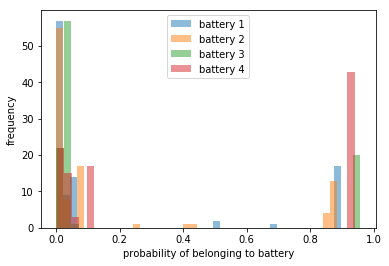

In [932]:
for i in range(4):
    plt.hist(pred_W[:, i], alpha = 0.5, bins = 40, label = "battery " + str(i+1));

plt.ylabel ('frequency');
plt.xlabel ('probability of belonging to battery');
plt.legend();

Finally, I find which genes belong to which battery, taking into account the moonlighting genes.

In [935]:
clusters_pred = [set(), set(), set(), set()]
for i in range(len(pred_W)):
    clusters_pred[np.argmax(pred_W[i])].add(i)

#manually add the moonlighting genes. Note that this step is specific to this run of the algorithm! 
#for future runs one would need to alter the indicies to match the batteries reported from the moonlighting genes.

for element in moonlighters_set:
    if element in clusters_pred[0]:
        clusters_pred[1].add(element)
    else:
        clusters_pred[0].add(element)

for i in range(len(clusters_pred)):
    print("battery %i has %i elements, consisting of:" %(i+1, len(clusters_pred[i])))
    for index in clusters_pred[i]:
        print(adler_data.index[index] + ", ", end = '')
    print("\n \n")

battery 1 has 20 elements, consisting of:
anise, apricot, elderberry, arugula, fennel, fig, gooseberry, oregano, blueberry, okra, thyme, leek, cayenne, lentil, raisin, rosemary, melon, mushroom, cranberry, currant, 
 

battery 2 has 20 elements, consisting of:
watermelon, fennel, zucchini, garlic, fig, pear, beet, nectarine, persimmon, plum, huckleberry, juniper, tangerine, lavender, lettuce, rhubarb, scallion, mulberry, coriander, currant, 
 

battery 3 has 20 elements, consisting of:
watercress, artichoke, parsnip, asparagus, ginger, banana, peach, plantain, broccoli, pomegranate, caraway, radish, cauliflower, celery, chard, lime, spinach, tomato, turnip, orange, 
 

battery 4 has 43 elements, consisting of:
avocado, basil, blackberry, butternut, cabbage, cantaloupe, carrot, cherry, chestnut, chickpea, cilantro, clementine, coconut, cucumber, eggplant, endive, grape, grapefruit, guava, honeydew, horseradish, kiwi, kohlrabi, maize, mango, mustard, olive, onion, papaya, parsley, pea, p